# IMDB Sentiment Analysis - Complete Pipeline

This notebook provides a complete pipeline for training, testing, and comparing sentiment analysis models on the IMDB reviews dataset.

In [1]:
%pip install tensorflow tensorflow-datasets scikit-learn matplotlib numpy

  Using cached tensorflow_datasets-4.9.9-py3-none-any.whl.metadata (11 kB)
  Using cached tensorflow_datasets-4.9.9-py3-none-any.whl.metadata (11 kB)
  Using cached dm_tree-0.1.9-cp310-cp310-macosx_10_9_universal2.whl.metadata (2.4 kB)
  Using cached dm_tree-0.1.9-cp310-cp310-macosx_10_9_universal2.whl.metadata (2.4 kB)
  Using cached immutabledict-4.2.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Installing build dependencies ... Collecting immutabledict (from tensorflow-datasets)
  Using cached immutabledict-4.2.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... -done
  Preparing metadata (pyproject.toml) ... one
  Preparing metadata (pyproject.toml) ... -done
done
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB

## Step 1: Imports and Configuration

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import json
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Create model_data directory if it doesn't exist
MODEL_DIR = "model_data"
os.makedirs(MODEL_DIR, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.1
GPU Available: []


## Step 2: Load Dataset and Visualize Sample

In [3]:
# Load IMDB reviews dataset
train_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
)

# Display a sample from the dataset
print("=" * 80)
print("SAMPLE REVIEW FROM DATASET")
print("=" * 80)

for text, label in train_ds.take(1):
    sample_text = text.numpy().decode('utf-8')
    sample_label = label.numpy()
    print(f"\nReview Text:\n{sample_text}\n")
    print(f"Label: {sample_label} ({'Positive' if sample_label == 1 else 'Negative'})")
    print("=" * 80)

SAMPLE REVIEW FROM DATASET

Review Text:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

Label: 0 (Negative)


2025-11-20 20:35:51.865245: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-20 20:35:51.869387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-20 20:35:51.869693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 3: Create Text Vectorization Layer

In [4]:
# Hyperparameters for text processing
vocab_size = 10000  # Top 10,000 most frequent words
seq_length = 250    # Maximum review length in words

# Create TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq_length
)

# Learn vocabulary from training data
train_text = train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

print(f"Vocabulary size: {vocab_size}")
print(f"Sequence length: {seq_length}")
print(f"Vocabulary learned from {len(list(train_text))} training samples")

2025-11-20 20:36:32.019804: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary size: 10000
Sequence length: 250
Vocabulary learned from 25000 training samples
Vocabulary learned from 25000 training samples


## Step 4: Prepare Data Pipeline

In [5]:
# Preprocessing function
def preprocess_text(text, label):
    text = vectorize_layer(text)
    return text, label

# Batch size
batch_size = 32

# Prepare training dataset with shuffling, batching, and prefetching
train_ds_prepared = (
    train_ds
    .shuffle(10000)
    .map(preprocess_text, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare test dataset (no shuffling needed for testing)
test_ds_prepared = (
    test_ds
    .map(preprocess_text, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Batch size: {batch_size}")
print("Data pipeline prepared successfully!")

Batch size: 32
Data pipeline prepared successfully!


## Step 5: Configure Model Name (Set this before training!)

In [6]:
# ====== CHANGE THIS VARIABLE BEFORE TRAINING ======
MODEL_NAME = "baseline_model"  # Change this to describe your model
# ==================================================

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"{MODEL_NAME}_{timestamp}"
model_path = os.path.join(MODEL_DIR, model_filename)

print(f"Model will be saved as: {model_filename}")
print(f"Full path: {model_path}")

Model will be saved as: baseline_model_20251120_203633
Full path: model_data/baseline_model_20251120_203633


## Step 6: Build Model Architecture

In [16]:
# Model hyperparameters
embedding_dim = 64
hidden_units = 64
epochs = 3

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(hidden_units, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
model.build(input_shape=(None, seq_length))
model.summary()

# Store model configuration for later saving
model_config = {
    "model_name": MODEL_NAME,
    "timestamp": timestamp,
    "architecture": {
        "vocab_size": vocab_size,
        "seq_length": seq_length,
        "embedding_dim": embedding_dim,
        "hidden_units": hidden_units,
        "optimizer": "adam",
        "loss": "binary_crossentropy"
    },
    "training_params": {
        "batch_size": batch_size,
        "epochs": epochs
    }
}

/Users/haidermalik/Documents/Code/CS_NOTES/Machine_Learning/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,225 (2.46 MB)

 Trainable params: 644,225 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Train the Model

In [8]:
# Train the model (only fitting, no validation evaluation yet)
print(f"Training {MODEL_NAME}...")
print("=" * 80)

history = model.fit(
    train_ds_prepared,
    epochs=epochs,
    verbose=1
)

print("\n" + "=" * 80)
print("Training complete!")
print("=" * 80)

Training baseline_model...
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7699 - loss: 0.4701
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7699 - loss: 0.4701
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8819 - loss: 0.2845
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8819 - loss: 0.2845
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9026 - loss: 0.2397

Training complete!
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9026 - loss: 0.2397

Training complete!


## Step 8: Evaluate Model on Test Set

In [9]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_ds_prepared, verbose=1)

# Get predictions for all test data
print("\nGenerating predictions...")
y_true = []
y_pred_probs = []

for texts, labels in test_ds_prepared:
    predictions = model.predict(texts, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate comprehensive metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("\n" + "=" * 80)
print("EVALUATION METRICS")
print("=" * 80)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC AUC Score:  {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(f"                Predicted Negative  Predicted Positive")
print(f"Actual Negative        {cm[0,0]:5d}              {cm[0,1]:5d}")
print(f"Actual Positive        {cm[1,0]:5d}              {cm[1,1]:5d}")
print("=" * 80)

# Store metrics in config
model_config["metrics"] = {
    "test_loss": float(test_loss),
    "test_accuracy": float(test_accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "roc_auc": float(roc_auc),
    "confusion_matrix": cm.tolist()
}

Evaluating model on test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8615 - loss: 0.3349
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8615 - loss: 0.3349

Generating predictions...

Generating predictions...

EVALUATION METRICS
Test Loss:      0.3349
Test Accuracy:  0.8615
Precision:      0.8205
Recall:         0.9254
F1 Score:       0.8698
ROC AUC Score:  0.9405

Confusion Matrix:
                Predicted Negative  Predicted Positive
Actual Negative         9969               2531
Actual Positive          932              11568

EVALUATION METRICS
Test Loss:      0.3349
Test Accuracy:  0.8615
Precision:      0.8205
Recall:         0.9254
F1 Score:       0.8698
ROC AUC Score:  0.9405

Confusion Matrix:
                Predicted Negative  Predicted Positive
Actual Negative         9969               2531
Actual Positive          932              11568


2025-11-20 20:37:12.644973: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 9: Test Single Example (Detailed Prediction)

In [10]:
# Get one example from test set for detailed analysis
print("=" * 80)
print("SINGLE TEST EXAMPLE - DETAILED PREDICTION")
print("=" * 80)

for text, label in test_ds.take(1):
    # Get the original text
    original_text = text.numpy().decode('utf-8')
    true_label = label.numpy()
    
    # Preprocess and predict
    preprocessed = vectorize_layer(tf.expand_dims(text, 0))
    prediction_prob = model.predict(preprocessed, verbose=0)[0][0]
    predicted_label = 1 if prediction_prob > 0.5 else 0
    
    # Display results
    print(f"\nReview Text:\n{original_text}\n")
    print("-" * 80)
    print(f"True Label:           {true_label} ({'Positive' if true_label == 1 else 'Negative'})")
    print(f"Predicted Label:      {predicted_label} ({'Positive' if predicted_label == 1 else 'Negative'})")
    print(f"Prediction Confidence: {prediction_prob:.4f} ({prediction_prob*100:.2f}%)")
    print(f"Correct Prediction:   {'✓ YES' if predicted_label == true_label else '✗ NO'}")
    print("=" * 80)

SINGLE TEST EXAMPLE - DETAILED PREDICTION

Review Text:
There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.

---

## Step 10: Save Model and Metrics

In [11]:
# Save the model
model_file = f"{model_path}.h5"
model.save(model_file)
print(f"✓ Model saved to: {model_file}")

# Save the metrics and configuration
metrics_file = f"{model_path}.json"
with open(metrics_file, 'w') as f:
    json.dump(model_config, f, indent=4)
print(f"✓ Metrics saved to: {metrics_file}")

print("\n" + "=" * 80)
print("MODEL AND METRICS SAVED SUCCESSFULLY!")
print("=" * 80)

✓ Model saved to: model_data/baseline_model_20251120_203633.h5
✓ Metrics saved to: model_data/baseline_model_20251120_203633.json

MODEL AND METRICS SAVED SUCCESSFULLY!


---
## MODEL COMPARISON AND RANKING SYSTEM

Run the cells below to compare all trained models and see rankings.

## Step 11: Load and Rank All Models

In [12]:
import glob

# Load all model metrics from the model_data directory
def load_all_models():
    """Load metrics for all trained models"""
    json_files = glob.glob(os.path.join(MODEL_DIR, "*.json"))
    
    if not json_files:
        print("No trained models found in model_data directory.")
        print("Train a model first by running the cells above!")
        return []
    
    models_data = []
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                # Add filename for reference
                data['filename'] = os.path.basename(json_file).replace('.json', '')
                models_data.append(data)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return models_data

# Load all models
all_models = load_all_models()
print(f"Found {len(all_models)} trained model(s)")


Found 1 trained model(s)


## Step 12: Rank Models by Performance

In [13]:
def calculate_ranking_score(model_data):
    """
    Calculate a composite ranking score based on multiple metrics.
    Higher is better. Weighted combination of:
    - F1 Score (40%)
    - ROC AUC (30%)
    - Accuracy (20%)
    - Precision (10%)
    """
    metrics = model_data.get('metrics', {})
    
    f1 = metrics.get('f1_score', 0)
    roc_auc = metrics.get('roc_auc', 0)
    accuracy = metrics.get('test_accuracy', 0)
    precision = metrics.get('precision', 0)
    
    # Weighted score
    score = (f1 * 0.4) + (roc_auc * 0.3) + (accuracy * 0.2) + (precision * 0.1)
    return score

# Rank models
if all_models:
    for model in all_models:
        model['ranking_score'] = calculate_ranking_score(model)
    
    # Sort by ranking score (best first)
    ranked_models = sorted(all_models, key=lambda x: x['ranking_score'], reverse=True)
    
    # Display rankings
    print("=" * 100)
    print("MODEL RANKINGS (Best to Worst)")
    print("=" * 100)
    print(f"{'Rank':<6} {'Model Name':<35} {'F1':<8} {'ROC AUC':<8} {'Accuracy':<8} {'Score':<8}")
    print("-" * 100)
    
    for rank, model in enumerate(ranked_models, 1):
        name = model['model_name']
        timestamp = model['timestamp']
        metrics = model.get('metrics', {})
        
        f1 = metrics.get('f1_score', 0)
        roc_auc = metrics.get('roc_auc', 0)
        accuracy = metrics.get('test_accuracy', 0)
        score = model['ranking_score']
        
        display_name = f"{name} ({timestamp})"
        print(f"{rank:<6} {display_name:<35} {f1:<8.4f} {roc_auc:<8.4f} {accuracy:<8.4f} {score:<8.4f}")
    
    print("=" * 100)
else:
    print("No models to rank. Train some models first!")

MODEL RANKINGS (Best to Worst)
Rank   Model Name                          F1       ROC AUC  Accuracy Score   
----------------------------------------------------------------------------------------------------
1      baseline_model (20251120_203633)    0.8698   0.9405   0.8615   0.8844  


## Step 13: Display Best Model in Detail

In [14]:
if all_models and ranked_models:
    best_model = ranked_models[0]
    
    print("\n" + "=" * 100)
    print("🏆 BEST MODEL - DETAILED INFORMATION")
    print("=" * 100)
    
    print(f"\n📋 MODEL IDENTIFICATION")
    print(f"   Name:           {best_model['model_name']}")
    print(f"   Timestamp:      {best_model['timestamp']}")
    print(f"   Filename:       {best_model['filename']}")
    print(f"   Ranking Score:  {best_model['ranking_score']:.6f}")
    
    print(f"\n🏗️  MODEL ARCHITECTURE")
    arch = best_model.get('architecture', {})
    print(f"   Vocabulary Size:    {arch.get('vocab_size', 'N/A')}")
    print(f"   Sequence Length:    {arch.get('seq_length', 'N/A')}")
    print(f"   Embedding Dim:      {arch.get('embedding_dim', 'N/A')}")
    print(f"   Hidden Units:       {arch.get('hidden_units', 'N/A')}")
    print(f"   Optimizer:          {arch.get('optimizer', 'N/A')}")
    print(f"   Loss Function:      {arch.get('loss', 'N/A')}")
    
    print(f"\n⚙️  TRAINING PARAMETERS")
    params = best_model.get('training_params', {})
    print(f"   Batch Size:         {params.get('batch_size', 'N/A')}")
    print(f"   Epochs:             {params.get('epochs', 'N/A')}")
    
    print(f"\n📊 PERFORMANCE METRICS")
    metrics = best_model.get('metrics', {})
    print(f"   Test Accuracy:      {metrics.get('test_accuracy', 0):.4f} ({metrics.get('test_accuracy', 0)*100:.2f}%)")
    print(f"   Test Loss:          {metrics.get('test_loss', 0):.4f}")
    print(f"   Precision:          {metrics.get('precision', 0):.4f}")
    print(f"   Recall:             {metrics.get('recall', 0):.4f}")
    print(f"   F1 Score:           {metrics.get('f1_score', 0):.4f}")
    print(f"   ROC AUC Score:      {metrics.get('roc_auc', 0):.4f}")
    
    print(f"\n📈 CONFUSION MATRIX")
    cm = metrics.get('confusion_matrix', [[0, 0], [0, 0]])
    print(f"                      Predicted Negative    Predicted Positive")
    print(f"   Actual Negative          {cm[0][0]:6d}                {cm[0][1]:6d}")
    print(f"   Actual Positive          {cm[1][0]:6d}                {cm[1][1]:6d}")
    
    # Calculate additional insights
    total = sum(sum(row) for row in cm)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    print(f"\n💡 ADDITIONAL INSIGHTS")
    print(f"   True Negatives:     {tn:6d} ({tn/total*100:.2f}%)")
    print(f"   False Positives:    {fp:6d} ({fp/total*100:.2f}%)")
    print(f"   False Negatives:    {fn:6d} ({fn/total*100:.2f}%)")
    print(f"   True Positives:     {tp:6d} ({tp/total*100:.2f}%)")
    print(f"   Total Predictions:  {total:6d}")
    
    print("\n" + "=" * 100)
else:
    print("No models available for detailed display.")


🏆 BEST MODEL - DETAILED INFORMATION

📋 MODEL IDENTIFICATION
   Name:           baseline_model
   Timestamp:      20251120_203633
   Filename:       baseline_model_20251120_203633
   Ranking Score:  0.884405

🏗️  MODEL ARCHITECTURE
   Vocabulary Size:    10000
   Sequence Length:    250
   Embedding Dim:      64
   Hidden Units:       64
   Optimizer:          adam
   Loss Function:      binary_crossentropy

⚙️  TRAINING PARAMETERS
   Batch Size:         32
   Epochs:             3

📊 PERFORMANCE METRICS
   Test Accuracy:      0.8615 (86.15%)
   Test Loss:          0.3349
   Precision:          0.8205
   Recall:             0.9254
   F1 Score:           0.8698
   ROC AUC Score:      0.9405

📈 CONFUSION MATRIX
                      Predicted Negative    Predicted Positive
   Actual Negative            9969                  2531
   Actual Positive             932                 11568

💡 ADDITIONAL INSIGHTS
   True Negatives:       9969 (39.88%)
   False Positives:      2531 (10.12%)
   

## Step 14: Visualize Model Comparison

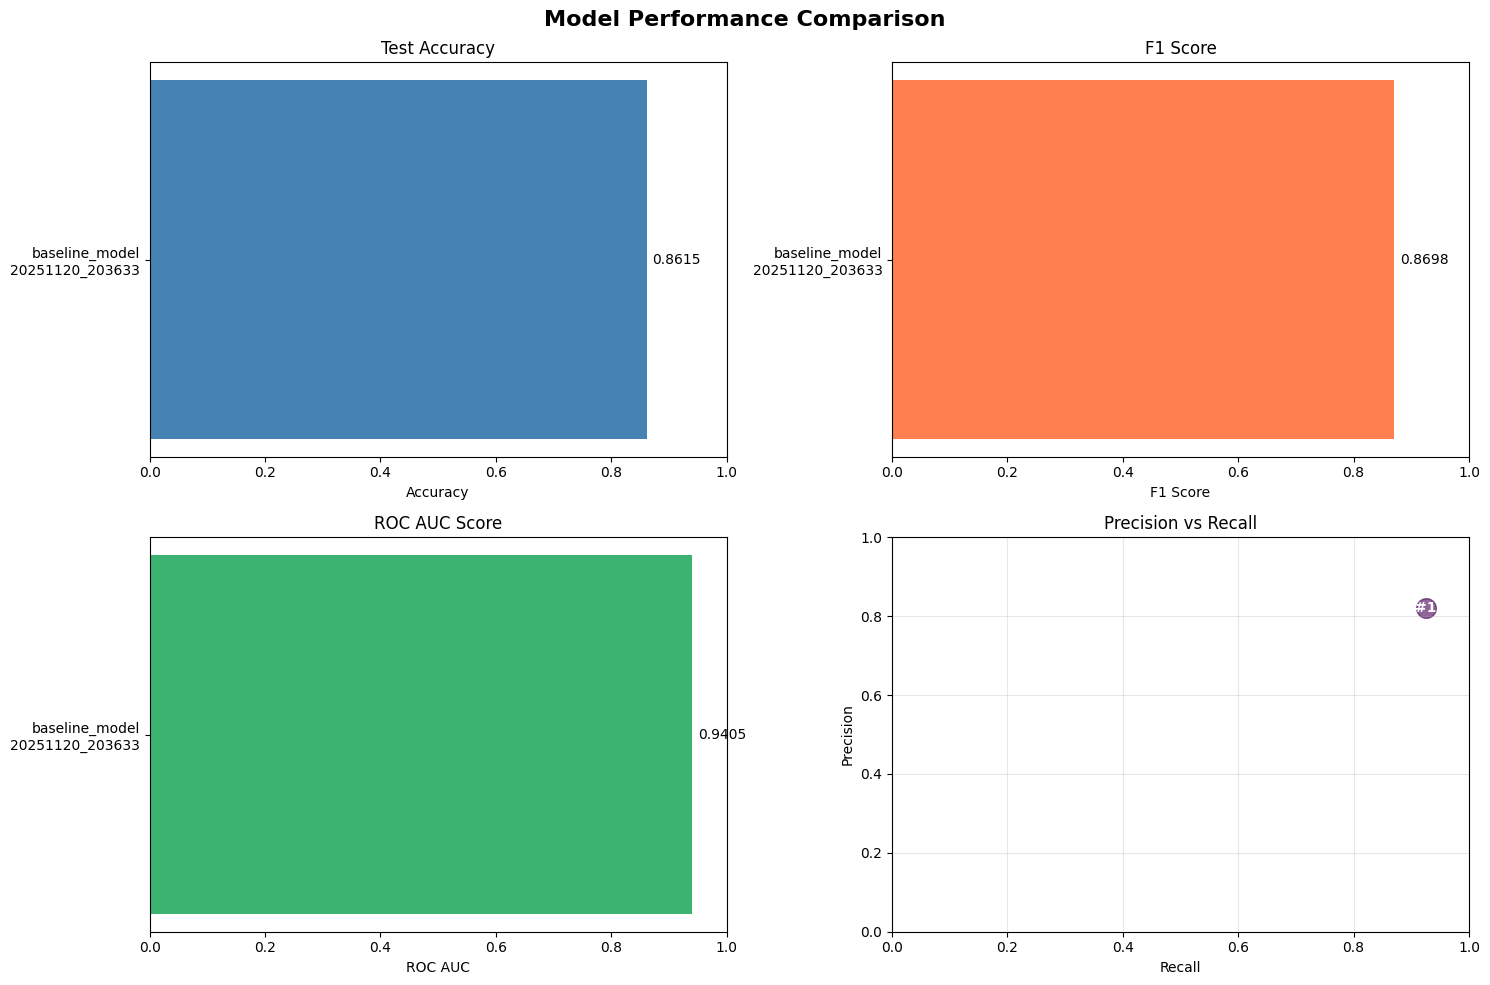

✓ Visualization complete!


In [15]:
if all_models and len(ranked_models) > 0:
    # Prepare data for visualization
    model_names = [f"{m['model_name']}\n{m['timestamp']}" for m in ranked_models]
    accuracies = [m['metrics'].get('test_accuracy', 0) for m in ranked_models]
    f1_scores = [m['metrics'].get('f1_score', 0) for m in ranked_models]
    roc_aucs = [m['metrics'].get('roc_auc', 0) for m in ranked_models]
    precisions = [m['metrics'].get('precision', 0) for m in ranked_models]
    recalls = [m['metrics'].get('recall', 0) for m in ranked_models]
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: Accuracy comparison
    axes[0, 0].barh(model_names, accuracies, color='steelblue')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_title('Test Accuracy')
    axes[0, 0].set_xlim(0, 1)
    for i, v in enumerate(accuracies):
        axes[0, 0].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # Plot 2: F1 Score comparison
    axes[0, 1].barh(model_names, f1_scores, color='coral')
    axes[0, 1].set_xlabel('F1 Score')
    axes[0, 1].set_title('F1 Score')
    axes[0, 1].set_xlim(0, 1)
    for i, v in enumerate(f1_scores):
        axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # Plot 3: ROC AUC comparison
    axes[1, 0].barh(model_names, roc_aucs, color='mediumseagreen')
    axes[1, 0].set_xlabel('ROC AUC')
    axes[1, 0].set_title('ROC AUC Score')
    axes[1, 0].set_xlim(0, 1)
    for i, v in enumerate(roc_aucs):
        axes[1, 0].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # Plot 4: Precision vs Recall
    axes[1, 1].scatter(recalls, precisions, s=200, alpha=0.6, c=range(len(model_names)), cmap='viridis')
    for i, name in enumerate(model_names):
        axes[1, 1].annotate(f'#{i+1}', (recalls[i], precisions[i]), 
                           ha='center', va='center', fontweight='bold', color='white')
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision vs Recall')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete!")
else:
    print("Need at least one model to visualize. Train some models first!")